In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#removing unecessary columns that have no effect on survival
df=df.drop(columns=['Cabin', 'Ticket', 'Name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [6]:
df=df.drop(index=df[df['Embarked'].isnull()].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Sex          889 non-null    object 
 4   Age          712 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Fare         889 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 69.5+ KB


In [7]:
df["Sex"]= df["Sex"].map({'male':0,'female':1})
df["Embarked"]= df["Embarked"].map({'S':0,'C':1,'Q':2})

<Axes: >

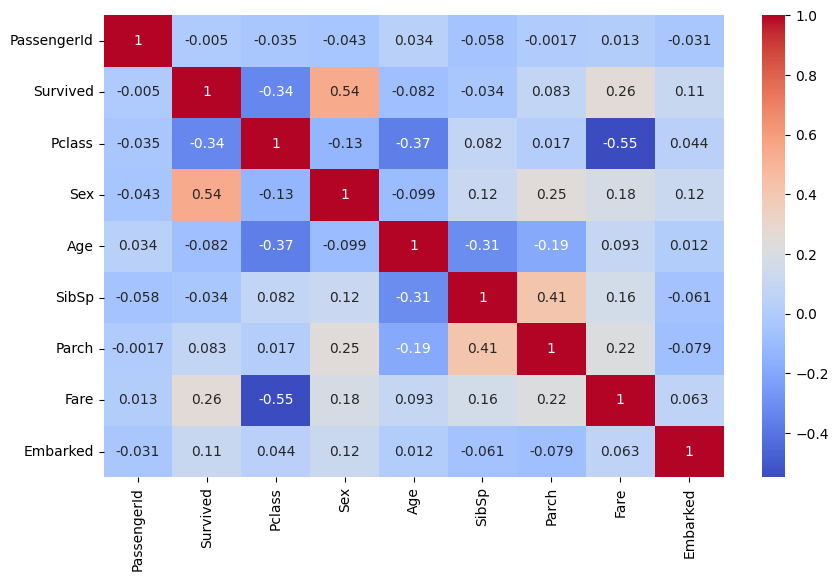

In [8]:
#visualizing correlation between features
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [9]:
#filling null age values 
#Age is highly correlated with Pclass so we will use median age per Pclass to fill null values
for pclass in df['Pclass'].unique():
    median_age=df[df['Pclass']==pclass]['Age'].median()
    df.loc[(df['Age'].isnull()) & (df['Pclass']==pclass), 'Age']=median_age
for fare in df['Pclass'].unique():
        median_fare=df[df['Pclass']==fare]['Fare'].median()
        df.loc[(df['Fare']==0) & (df['Pclass']==fare), 'Fare']=median_fare

<Axes: >

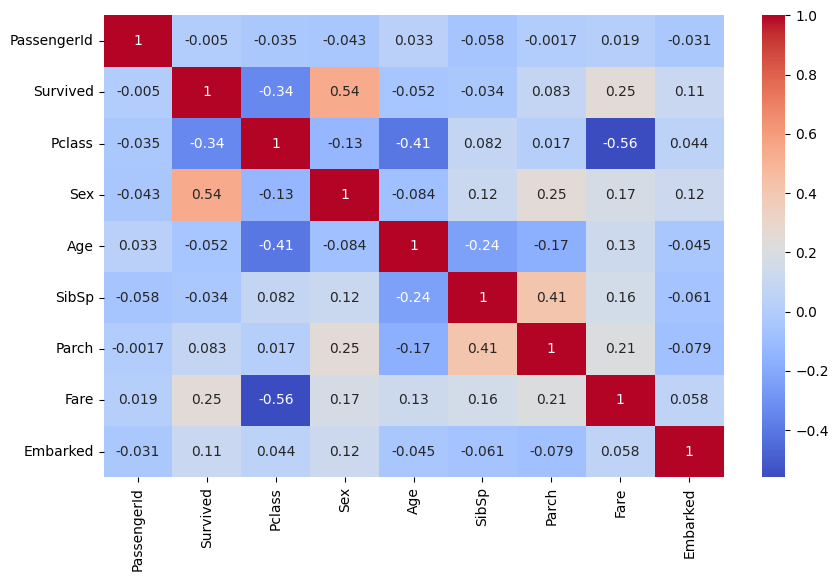

In [10]:
#visualizing correlation between features
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## HeatMap Interpratation
The above correlation heat map shows that, The survival chances of passengers is heavily reliant on Pclass and Sex. It is also correlated with features such as fare but this is a secondary correlation as a higher passenger class leads to a higher fare and higher passenger classes had a higher chance of survival.

In [11]:
# performing k-fold cross-validation
model=LogisticRegression(max_iter=500)
X=df.drop(columns=['Survived','PassengerId'])
y=df['Survived']
# define kfold cross-validator
def evaluate_model(model, X, y, k=5):
    """
    Evaluate a classification model using K-Fold cross-validation.
    Returns mean Accuracy, F1-score, and ROC-AUC.
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    acc = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    f1 = cross_val_score(model, X, y, cv=kfold, scoring='f1').mean()
    roc = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Accuracy: {acc:.3f}")
    print(f"Mean F1-score: {f1:.3f}")
    print(f"Mean ROC-AUC: {roc:.3f}")
evaluate_model(model, X, y)


Model: LogisticRegression
Mean Accuracy: 0.804
Mean F1-score: 0.732
Mean ROC-AUC: 0.850


In [12]:
#actually fitting the model
model.fit(X,y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [13]:
#visualizing feature importance
importance = model.coef_[0]

In [14]:
testdata=pd.read_csv('test.csv')
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [15]:
#testdata=testdata.drop(columns=['Cabin', 'Ticket', 'Name'])
testdata['Age']= testdata['Age'].fillna(testdata.groupby('Pclass')['Age'].transform('median'))
testdata["Embarked"]= testdata["Embarked"].map({'S':0,'C':1,'Q':2})
testdata["Sex"]= testdata["Sex"].map({'male':0,"female":1})

In [16]:
#checking row missing fare value and filling it with a median fare for passengers in the same Pclass
print(testdata[testdata['Fare'].isnull()])
testdata.loc[testdata['Fare'].isnull(), 'Fare']=testdata[testdata['Pclass']==3]['Fare'].median()

for fare in df['Pclass'].unique():
        median_fare=df[df['Pclass']==fare]['Fare'].median()
        df.loc[(df['Fare']==0) & (df['Pclass']==fare), 'Fare']=median_fare

     PassengerId  Pclass                Name  Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas    0  60.5      0      0   3701   

     Fare Cabin  Embarked  
152   NaN   NaN         0  


In [17]:
predictions=model.predict(testdata.drop(columns=['PassengerId', 'Cabin', 'Ticket', 'Name']))
output=pd.DataFrame({'PassengerId':testdata['PassengerId'],'Survived':predictions})
output.to_csv('submission.csv',index=False) 